# Spread in Primary Quanta (from NEST)

In [2]:
#imports

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy.special import binom as binomcoeff
from scipy.optimize import curve_fit
from scipy.integrate import quad
import datetime
import pprint
import math
import os
from matplotlib.ticker import AutoMinorLocator
import subprocess
import json

#including the SFS libraries
import sys
sys.path.append("./../../") 
import SF
import SF_spectrum
import SF_process
import SF_nestcom

In [3]:
#lateX plotting settings

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
#rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

In [7]:
#definitions: general
studyname = "_"
output_folder = "./data/"
flag_generatedata = False
flag_loaddata = True

#definitions: simulation parameters
number_of_events_per_energy_val = 10000
interactiontype = "ER"
#spectrumname = "spectrum_" +SF_nestcom.datestring() +"_" +interactiontype
spectrumname = "spectrum_" +"20200601_" +interactiontype
detectorname = "dummydetector"
number_of_energy_values = 300
energy_range = [0.5,3000] #NOTE: 0 is no viable energy deposition value!
paramrange_edep = list(np.linspace(start=energy_range[0], stop=energy_range[1], num=number_of_energy_values, endpoint=True))
paramrange_edrift = [50, 100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 5000]
#NOTE: 0 is also no viable electrical drift field value!

#definitions: plotting
colors = [
    "blue", # 50 V/cm
    "orange", # 100 V/cm
    "green", # 250 V/cm
    "red", # 500 V/cm
    "purple", # 750 V/cm
    "brown", # 1000 V/cm
    "pink", # 1500 V/cm
    "grey", # 2000 V/cm
    "chartreuse", # 2500 V/cm
    "cyan", # 3000 V/cm
    "blue", # 5000 V/cm
]

In [8]:
#generate data

if flag_generatedata == True:

    # saving the spectrum.npy file from the data defined above
    SF_spectrum.gen_gnampfino_parametersweep(
        name = spectrumname,
        savefolder = output_folder,
        number_of_samples_per_run = number_of_events_per_energy_val,
        paramrange_interactiontype = [interactiontype],
        paramrange_energydeposition = paramrange_edep,
        paramrange_edrift = paramrange_edrift
    )

    # generating the raw data running NEST
    SF_nestcom.SF_nestcom_runnest(
        filestring_spectrum = output_folder +spectrumname,
        detectorname = detectorname,
        path_testnest = SF.path_testnest,
        pathstring_output = output_folder,
        flag_deletetxt = True
    )

    # processing the data
    SF_process.gen_summarized_ndarray(
        input_folder = output_folder,
        ndarray = "sf_output__" +spectrumname +"__" +detectorname +".npy",
        output_folder = output_folder
    )

    # renaming the data
    subprocess.call("mv " +output_folder +spectrumname +".npy "+output_folder +studyname +"__" +spectrumname +".npy", shell=True)
    subprocess.call("mv " +output_folder +"sf_output" +"__" +spectrumname +"__" +detectorname +".npy "+output_folder +studyname +"__" +"sf_output" +"__" +spectrumname +"__" +detectorname +".npy", shell=True)
    subprocess.call("mv " +output_folder +"sf_output" +"__" +spectrumname +"__" +detectorname +"__PROCESSED.npy "+output_folder +studyname +"__" +"sf_output" +"__" +spectrumname +"__" +detectorname +"__PROCESSED.npy", shell=True)
    
    # deleting the raw data
    subprocess.call("rm " +output_folder +studyname +"__" +"sf_output" +"__" +spectrumname +"__" +detectorname +".npy", shell=True)
  

In [9]:
#load data if already generated

if flag_loaddata == True:

    ### loading the processed data
    processed_data = np.load(output_folder +studyname +"__" +"sf_output" +"__" +spectrumname +"__" +detectorname +"__PROCESSED.npy")

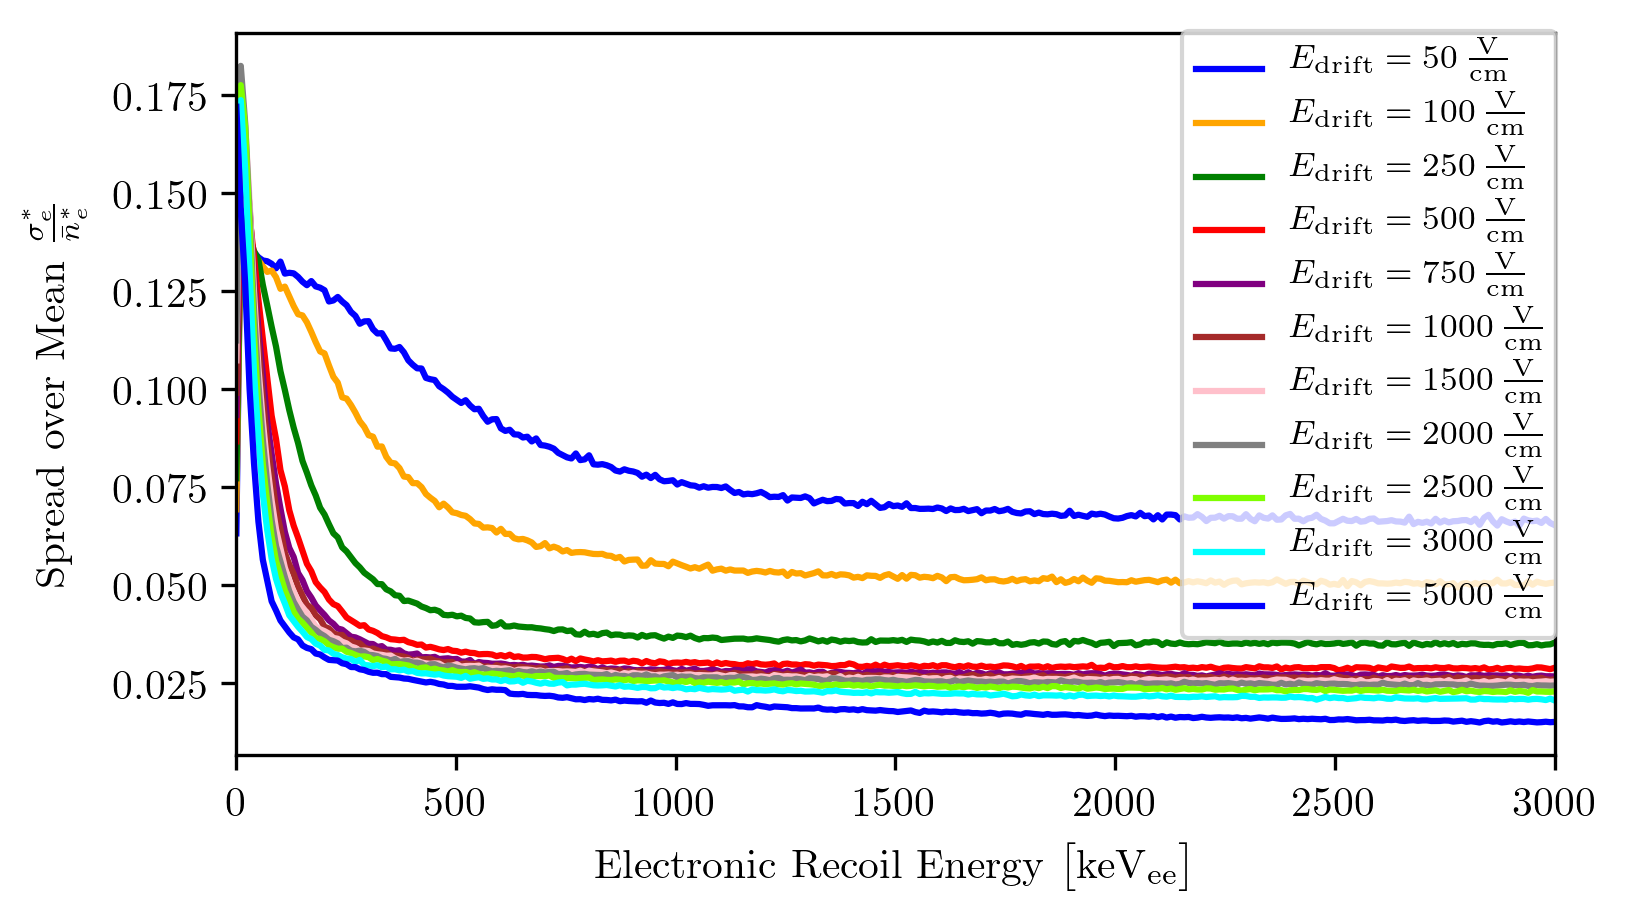

In [19]:
#plotting the ratio of spreads over corresponding means of the distribution

fig, ax1 = plt.subplots(figsize=(5.670, 3.189), dpi=300)
for i in range(len(paramrange_edrift)):
    ratios = ratio = np.divide(processed_data["mean_number_of_electrons_sigma"][(processed_data["field_strength"]==paramrange_edrift[i])], processed_data["mean_number_of_electrons"][(processed_data["field_strength"]==paramrange_edrift[i])])
    plt.plot(processed_data["energy_deposition"][(processed_data["field_strength"]==paramrange_edrift[i])], ratios, c=colors[i], alpha=1.00, label=r"$E_{\mathrm{drift}}=" +f"{paramrange_edrift[i]}" +r"\,\mathrm{\frac{V}{cm}}$")

#aspect
ax1.set_xlim([np.min(paramrange_edep),np.max(paramrange_edep)])
 #ax1.set_xscale("log")
#ax1.set_ylim([0,75])
ax1.set_xlabel(r"Electronic Recoil Energy $\big[\mathrm{keV}_{\mathrm{ee}}\big]$")
ax1.set_ylabel(r"Spread over Mean $\frac{\sigma^{*}_{e}}{\bar{n}^{*}_{e}}$")
leg = plt.legend(fontsize=8, labelspacing=0.3, bbox_to_anchor=(0.705,0.14))
plt.show()
fig.savefig(output_folder +studyname +"__spread_over_mean")
plt.close(fig)

------